In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

from missingpy import MissForest

In [2]:
df = pd.read_csv('./data/galaxy.csv')
df_cleaned = pd.read_csv('./data/galaxy-cleaned.csv', index_col=0)
df_cleaned_scaled = pd.read_csv('./data/galaxy-cleaned-scaled.csv', index_col=0)

# 만족스럽지 못한 성능!
- 각 model에 대한 '싯가' 관련 feature engineering을 추가하면 어떨까?
    - 각 model에 대한 싯가 분포를 구하고, startprice 관측값이 해당 분포에서 확률이 어떻게 되는지 알 수 있을까?
    

In [3]:
df_cleaned

,BuyItNow,startprice,hasDescription,upperCaseDescription,sold,has_carrier,has_color,has_productline,modelNumber,isNote
0,0,199.99,0,0,1,1,1,1,3,0
1,0,235.00,0,0,0,1,0,1,3,1
2,0,199.99,1,1,0,0,0,0,2,0
3,1,175.00,0,0,1,1,1,1,3,1
4,1,100.00,0,0,1,1,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...
1480,0,89.50,1,1,0,1,0,1,1,0
1481,0,239.95,1,1,1,1,1,1,3,0
1482,0,329.99,1,1,0,1,1,1,4,1
1483,0,89.00,1,1,1,1,1,1,1,0


<AxesSubplot:>

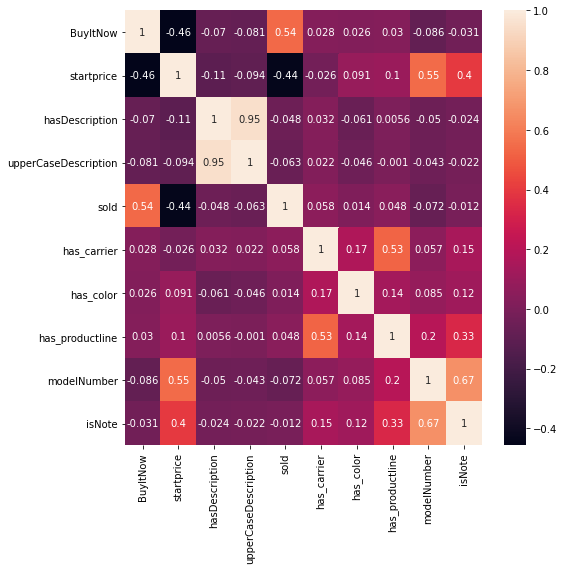

In [28]:
plt.figure(figsize=(8,8))
sns.heatmap(df_cleaned.corr(), annot=True)

In [28]:
# has_color, has_carrier, has_productline 정보
hasColor = df_cleaned['has_color']
hasProduct = df_cleaned['has_productline']
hasCarrier = df_cleaned['has_carrier']

perfectInfo = ((hasColor==1) & (hasProduct==1) & (hasCarrier==1))
leastInfo = ((hasColor==1) | (hasProduct==1) | (hasCarrier==1))
zeroInfo = ((hasColor==0) & (hasProduct==0) & (hasCarrier==0))

In [22]:
df_cleaned[perfectInfo]['modelNumber'].mean(), df_cleaned[zeroInfo]['modelNumber'].mean()

(2.6251748251748253, 2.0)

In [23]:
df_cleaned[perfectInfo]['sold'].mean(), df_cleaned[zeroInfo]['sold'].mean()

(0.4937062937062937, 0.41509433962264153)

/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


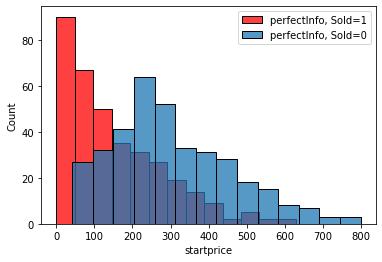

In [36]:
sns.histplot(df_cleaned[perfectInfo][df_cleaned['sold']==1]['startprice'], color='red')
sns.histplot(df_cleaned[perfectInfo][df_cleaned['sold']==0]['startprice'])
plt.legend(['perfectInfo, Sold=1', 'perfectInfo, Sold=0'])

/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


642 737


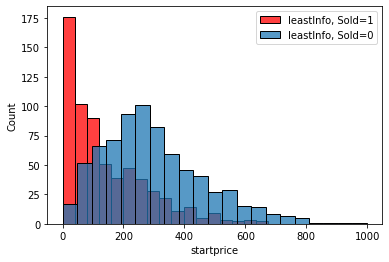

In [34]:
print(len(df_cleaned[leastInfo][df_cleaned['sold']==1]['startprice']),
         len(df_cleaned[leastInfo][df_cleaned['sold']==0]['startprice']))
sns.histplot(df_cleaned[leastInfo][df_cleaned['sold']==1]['startprice'], color='red')
sns.histplot(df_cleaned[leastInfo][df_cleaned['sold']==0]['startprice'])
plt.legend(['leastInfo, Sold=1', 'leastInfo, Sold=0'])
plt.show()

44 62


/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


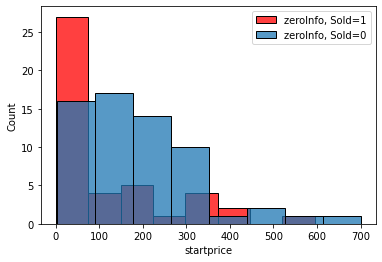

In [35]:
print(len(df_cleaned[zeroInfo][df_cleaned['sold']==1]['startprice']),
         len(df_cleaned[zeroInfo][df_cleaned['sold']==0]['startprice']))
sns.histplot(df_cleaned[zeroInfo][df_cleaned['sold']==1]['startprice'], color='red')
sns.histplot(df_cleaned[zeroInfo][df_cleaned['sold']==0]['startprice'])
plt.legend(['zeroInfo, Sold=1', 'zeroInfo, Sold=0'])
plt.show()

# Additional Drop & one-hot-encode `modelNumber`
`drop_first`=True or False?
- https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a

In [37]:
# hasDescription과 upperCaseDescription은 거의 동일한 정보
df_cleaned = df_cleaned.drop('upperCaseDescription', axis=1)

# has_color, has_productline, has_carrier는 가격과 거의 상관없는 정보
df_cleaned = df_cleaned.drop(['has_color',
                              'has_productline',
                              'has_carrier'], axis=1)

df_cleaned.head()

,BuyItNow,startprice,hasDescription,sold,modelNumber,isNote
0,0,199.99,0,1,3,0
1,0,235.00,0,0,3,1
2,0,199.99,1,0,2,0
3,1,175.00,0,1,3,1
4,1,100.00,0,1,2,0


In [40]:
modelNumber_dummies = pd.get_dummies(df_cleaned['modelNumber'], prefix='modelNumber')
modelNumber_dummies_df = pd.get_dummies(df_cleaned['modelNumber'], drop_first=True, prefix='modelNumber')

df_cleaned1 = pd.concat([df_cleaned,modelNumber_dummies], axis=1).drop('modelNumber', axis=1)
df_cleaned2 = pd.concat([df_cleaned,modelNumber_dummies_df], axis=1).drop('modelNumber', axis=1)

In [41]:
df_cleaned1.head()

,BuyItNow,startprice,hasDescription,sold,isNote,modelNumber_1,modelNumber_2,modelNumber_3,modelNumber_4
0,0,199.99,0,1,0,0,0,1,0
1,0,235.00,0,0,1,0,0,1,0
2,0,199.99,1,0,0,0,1,0,0
3,1,175.00,0,1,1,0,0,1,0
4,1,100.00,0,1,0,0,1,0,0


In [42]:
df_cleaned2.head()

,BuyItNow,startprice,hasDescription,sold,isNote,modelNumber_2,modelNumber_3,modelNumber_4
0,0,199.99,0,1,0,0,1,0
1,0,235.00,0,0,1,0,1,0
2,0,199.99,1,0,0,1,0,0
3,1,175.00,0,1,1,0,1,0
4,1,100.00,0,1,0,1,0,0


In [91]:
df[df['BuyItNow']==1].sold.mean()

0.760119940029985

In [92]:
df[df['BuyItNow']==0].sold.mean()

0.21882640586797067

# Ideation.
### Implement A Gaussian Process From Scratch
https://towardsdatascience.com/implement-a-gaussian-process-from-scratch-2a074a470bce

In [7]:
df.groupby(['productline', 'BuyItNow', 'sold'])['startprice'].mean().sort_values(ascending=False)

productline    BuyItNow  sold
Galaxy_Note10  0         0       468.784540
               1         0       416.711071
               0         1       400.213243
Galaxy_S10     0         1       336.333333
Galaxy_Note9   0         1       325.262000
                         0       317.981957
Galaxy_S9      0         0       317.914054
Galaxy_S10     0         0       296.917500
Galaxy_Note9   1         0       267.911667
Galaxy_Note8   0         0       258.026102
Galaxy_S8      0         0       248.551759
Galaxy_S9      1         0       236.517368
Unknown        0         1       232.497692
Galaxy_S9      0         1       232.071053
Unknown        1         0       216.254286
               0         0       208.135000
Galaxy_Note8   1         0       198.855000
               0         1       198.411765
Galaxy_Note10  1         1       185.255179
Galaxy_S8      0         1       182.019697
               1         0       173.103243
Galaxy_S10     1         1       160.000000
Ga

In [25]:
df[(df['sold']==1)]['startprice'].mean(), df[(df['sold']==0)]['startprice'].mean()

(134.09725947521866, 287.88843554443054)

In [15]:
df_cleaned.columns

Index(['BuyItNow', 'startprice', 'hasDescription', 'upperCaseDescription',
       'sold', 'has_carrier', 'has_color', 'has_productline', 'modelNumber',
       'isNote'],
      dtype='object')

In [17]:
df_cleaned.groupby(['modelNumber',
                    'isNote', 
                    'BuyItNow',
                    'sold',
                    'hasDescription'])['startprice'].mean().sort_values(ascending=False)

modelNumber  isNote  BuyItNow  sold  hasDescription
4            1       0         0     0                 506.064762
                     1         0     0                 470.747500
                     0         1     0                 415.646667
                               0     1                 412.053768
             0       0         1     0                 379.500000
             1       0         1     1                 358.543000
3            1       0         1     0                 343.999091
             0       0         0     0                 333.422083
             1       0         0     0                 322.983333
             0       0         0     1                 310.470200
             1       0         0     1                 308.604375
4            0       0         0     1                 303.670000
                                     0                 294.666667
             1       1         0     1                 281.620000
2            1       0  

In [18]:
df_cleaned.groupby(['modelNumber',
                    'isNote', 
                    'BuyItNow',
                    'sold',
                    'hasDescription'])['startprice'].std().sort_values(ascending=False)

modelNumber  isNote  BuyItNow  sold  hasDescription
4            1       1         1     0                 171.453448
                     0         0     0                 166.988778
2            0       0         0     0                 160.156469
                     1         0     0                 155.752636
4            1       1         0     0                 150.443857
3            0       0         0     0                 144.901914
4            1       0         1     1                 135.192013
                     1         1     1                 132.495070
2            1       0         0     0                 132.234681
             0       0         1     0                 132.228203
3            0       1         0     0                 125.691229
1            0       1         0     0                 123.533952
4            1       0         1     0                 121.607757
3            1       1         1     1                 119.884418
                        

# Data Split

In [48]:
X = df_cleaned.drop('sold', axis=1)
y = df_cleaned['sold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [69]:
# X0 = df.drop('sold', axis=1)
# y0 = df['sold']
# X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=11)

In [49]:
X1 = df_cleaned1.drop('sold', axis=1)
y1 = df_cleaned1.sold
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=11)

In [53]:
X2 = df_cleaned2.drop('sold', axis=1)
y2 = df_cleaned2.sold
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=11)

### X3/y3 -> `robustscaler` 검토... 그전에 이상치에 대해 검토해보자.

In [165]:
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
robustScaler.fit(X3)
robustScaler.transform(X3)

array([[ 0.        ,  0.00865217,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.        ,  0.16086957,  1.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.        ,  0.00865217,  0.        ,  1.        ,  0.        ,
         0.        ],
       ...,
       [ 0.        ,  0.57386957,  1.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.        , -0.47391304,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        , -0.33917391,  0.        ,  0.        ,  0.        ,
         0.        ]])

### log를 취하여 작은 차이를 상대적으로 더 크게?
- np.log(startprice)

In [192]:
X3 = df_cleaned2.drop(['sold', 'hasDescription'], axis=1)
#X3['startprice'] = np.log(X3['startprice'])
y3 = df_cleaned2.sold
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=11)

In [193]:
X3.head()

,BuyItNow,startprice,isNote,modelNumber_2,modelNumber_3,modelNumber_4
0,0,199.99,0,0,1,0
1,0,235.00,1,0,1,0
2,0,199.99,0,1,0,0
3,1,175.00,1,0,1,0
4,1,100.00,0,1,0,0


<AxesSubplot:xlabel='startprice', ylabel='Count'>

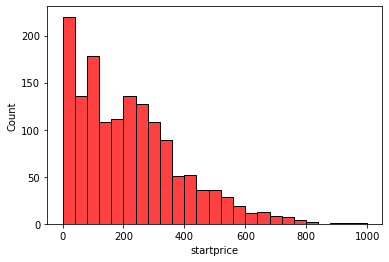

In [194]:
sns.histplot(X3['startprice'], color='red')

<AxesSubplot:xlabel='startprice', ylabel='Count'>

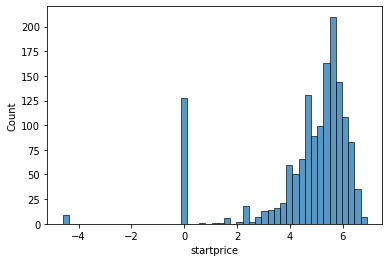

In [196]:
sns.histplot(np.log(df['startprice']))

# Modeling_Ensemble

In [54]:
def test_ensemble(X_train, y_train, X_test, y_test):
    clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
    clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
    clf3 = GaussianNB()
    # X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    # y = np.array([1, 1, 1, 2, 2, 2])

    eclf1 = VotingClassifier(estimators=[
             ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                             voting='hard')
    eclf1 = eclf1.fit(X_train, y_train)
    eclf1_pred = eclf1.predict(X_test)

    np.array_equal(eclf1.named_estimators_.lr.predict(X_test),
                    eclf1.named_estimators_['lr'].predict(X_test))

    eclf2 = VotingClassifier(estimators=[
             ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
             voting='soft')
    eclf2 = eclf2.fit(X_train, y_train)
    eclf2_pred = eclf2.predict(X_test)


    eclf3 = VotingClassifier(estimators=[
            ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
            voting='soft', weights=[2,1,1],
            flatten_transform=True)
    eclf3 = eclf3.fit(X_train, y_train)
    eclf3_pred = eclf3.predict(X_test)
    #print(eclf3.transform(X_test).shape)
    
    return accuracy_score(y_test, eclf1_pred), accuracy_score(y_test, eclf2_pred), accuracy_score(y_test, eclf3_pred)

In [55]:
test_ensemble(X_train, y_train, X_test, y_test)

(0.7845117845117845, 0.7912457912457912, 0.7811447811447811)

In [56]:
test_ensemble(X1_train, y1_train, X1_test, y1_test)

(0.7777777777777778, 0.7845117845117845, 0.7811447811447811)

In [57]:
test_ensemble(X2_train, y2_train, X2_test, y2_test)

/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

(0.7811447811447811, 0.7811447811447811, 0.7811447811447811)

In [188]:
test_ensemble(X3_train, y3_train, X3_test, y3_test)

(0.7744107744107744, 0.7777777777777778, 0.7912457912457912)

# Modeling_RandomForest

In [58]:
params = {
    'n_estimators':[50, 100, 150],
    'criterion':['gini', 'entropy'],
    'max_depth':[6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20]
}

In [63]:
def test_rf(X_train, y_train, X_test, y_test, p):
    params = p
    rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
    grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
    grid_cv.fit(X_train, y_train)

    pred = grid_cv.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(accuracy)
    return grid_cv

def show_feature_importances(grid_cv):
    ftr_importances_values = grid_cv.best_estimator_.feature_importances_
    ftr_importances_values = pd.Series(ftr_importances_values, index=X_train.columns)

    ftr_top20 = ftr_importances_values.sort_values(ascending=False)[:20]
    plt.figure(figsize=(8,6))
    plt.title('feature importance top 20')
    sns.barplot(x=ftr_top20, y=ftr_top20.index)
    plt.show()

In [64]:
X_rf_grid = test_rf(X_train, y_train, X_test, y_test, params)
X1_rf_grid = test_rf(X1_train, y1_train, X1_test, y1_test, params)
X2_rf_grid = test_rf(X2_train, y2_train, X2_test, y2_test, params)

0.8013468013468014
0.7946127946127947
0.797979797979798


In [189]:
X3_rf_grid = test_rf(X3_train, y3_train, X3_test, y3_test, params)

0.7946127946127947


# Logistic Regressor

In [154]:
def get_test_acc(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return model, accuracy_score(y_test, model.predict(X_test))

def test_grid(model, X_train, y_train, X_test, y_test, p):
    params = p
    model = model #RandomForestClassifier(random_state=0, n_jobs=-1)
    grid_cv = GridSearchCV(model, param_grid=params,
                           cv=StratifiedKFold(n_splits=5),
                           n_jobs=-1)
    grid_cv.fit(X_train, y_train)
    pred = grid_cv.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(accuracy)
    return grid_cv

In [180]:
logreg_p = {"C":np.logspace(-3, 3, 10),
             "penalty":["l1","l2"]}# l1 lasso l2 ridge
lr = LogisticRegression(multi_class='multinomial', random_state=1)

logreg_grid = test_grid(lr, X3_train, y3_train, X3_test, y3_test, logreg_p)

0.7912457912457912


/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [181]:
logreg_grid.best_params_

{'C': 46.41588833612773, 'penalty': 'l2'}

# Error Analysis

In [90]:
def result_df(grid_cv_fit, X, y):
    
    X_pred = pd.DataFrame(grid_cv_fit.predict(X),
                          columns=['sold_pred'])
    X_pred_proba = pd.DataFrame(grid_cv_fit.predict_proba(X),
                                columns=['sold0_proba', 'sold1_proba'])
    y = pd.DataFrame(y, columns=['sold'])
    
    res_df = pd.concat([X, y, X_pred, X_pred_proba], axis=1)
    res_df['wrong_pred'] = res_df['sold'] != res_df['sold_pred']
    
    return res_df

In [92]:
X2_rf_result = result_df(X2_rf_grid, X2, y2)
X2_rf_result.head()

,BuyItNow,startprice,hasDescription,isNote,modelNumber_2,modelNumber_3,modelNumber_4,sold,sold_pred,sold0_proba,sold1_proba,wrong_pred
0,0,199.99,0,0,0,1,0,1,0,0.566777,0.433223,True
1,0,235.00,0,1,0,1,0,0,0,0.762824,0.237176,False
2,0,199.99,1,0,1,0,0,0,0,0.826537,0.173463,False
3,1,175.00,0,1,0,1,0,1,1,0.192680,0.807320,False
4,1,100.00,0,0,1,0,0,1,1,0.304329,0.695671,False


In [93]:
X2_rf_result[X2_rf_result['wrong_pred']==1]

,BuyItNow,startprice,hasDescription,isNote,modelNumber_2,modelNumber_3,modelNumber_4,sold,sold_pred,sold0_proba,sold1_proba,wrong_pred
0,0,199.99,0,0,0,1,0,1,0,0.566777,0.433223,True
7,0,199.99,1,0,0,1,0,1,0,0.676896,0.323104,True
10,0,75.00,0,0,0,0,0,1,0,0.550112,0.449888,True
11,0,199.99,1,0,0,1,0,1,0,0.676896,0.323104,True
13,0,184.50,1,1,1,0,0,1,0,0.704286,0.295714,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1469,0,249.99,0,1,0,0,1,1,0,0.637298,0.362702,True
1472,0,36.95,1,0,0,0,0,0,1,0.428929,0.571071,True
1479,0,424.99,1,1,0,0,1,1,0,0.813536,0.186464,True
1481,0,239.95,1,0,0,1,0,1,0,0.737616,0.262384,True


### sold=1를 sold=0보다 2배 예측 못함


In [95]:
X2_rf_result[X2_rf_result['wrong_pred']==1].groupby('sold')['BuyItNow'].count()

sold
0     90
1    192
Name: BuyItNow, dtype: int64

In [208]:
wrong_pred = (X2_rf_result['wrong_pred']==1)
right_pred = (X2_rf_result['wrong_pred']==0)
not_sold = (X2_rf_result['sold']==0)
sold = (X2_rf_result['sold']==1)
not_BIN = (X2_rf_result['BuyItNow']==0)
BIN = (X2_rf_result['BuyItNow']==1)

X2_rf_result_sold0 = X2_rf_result[not_sold]
X2_rf_result_sold1 = X2_rf_result[sold]
X2_rf_result_wrong_sold0 = X2_rf_result[wrong_pred&not_sold]
X2_rf_result_wrong_sold1 = X2_rf_result[wrong_pred&sold]

In [101]:
X2_rf_result_wrong_sold1.groupby('BuyItNow')['sold'].count()

BuyItNow
0    169
1     23
Name: sold, dtype: int64

In [103]:
X2_rf_result_wrong_sold1_bin0 = X2_rf_result_wrong_sold1[not_BIN]

In [105]:
X2_rf_result_wrong_sold1_bin0

,BuyItNow,startprice,hasDescription,isNote,modelNumber_2,modelNumber_3,modelNumber_4,sold,sold_pred,sold0_proba,sold1_proba,wrong_pred
0,0,199.99,0,0,0,1,0,1,0,0.566777,0.433223,True
7,0,199.99,1,0,0,1,0,1,0,0.676896,0.323104,True
10,0,75.00,0,0,0,0,0,1,0,0.550112,0.449888,True
11,0,199.99,1,0,0,1,0,1,0,0.676896,0.323104,True
13,0,184.50,1,1,1,0,0,1,0,0.704286,0.295714,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1459,0,85.00,0,0,0,0,0,1,0,0.679138,0.320862,True
1469,0,249.99,0,1,0,0,1,1,0,0.637298,0.362702,True
1479,0,424.99,1,1,0,0,1,1,0,0.813536,0.186464,True
1481,0,239.95,1,0,0,1,0,1,0,0.737616,0.262384,True


In [113]:
X2_rf_result.groupby(['sold','BuyItNow','isNote',
                                       'modelNumber_2',
                                       'modelNumber_3',
                                       'modelNumber_4'])['startprice'].mean().\
                                        sort_values(ascending=False)

sold  BuyItNow  isNote  modelNumber_2  modelNumber_3  modelNumber_4
0     0         1       0              0              1                468.784540
      1         1       0              0              1                416.711071
1     0         1       0              0              1                400.213243
                0       0              0              1                336.333333
                1       0              1              0                325.262000
0     0         1       0              1              0                317.981957
                0       0              1              0                317.914054
                                       0              1                296.917500
      1         1       0              1              0                267.911667
      0         1       1              0              0                258.026102
      1         0       0              1              0                236.517368
1     0         0       0     

### BuyItNow=0이면서 팔린 모든 갤럭시 vs. BuyItNow=0이면서 팔렸지만 예측 틀린 갤럭시

<AxesSubplot:xlabel='startprice', ylabel='Count'>

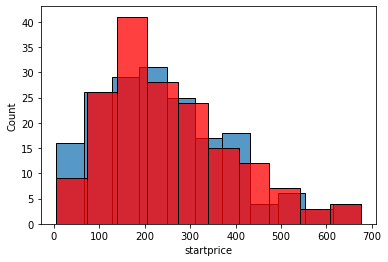

In [209]:
sns.histplot(X2_rf_result[sold&not_BIN]['startprice'])
sns.histplot(X2_rf_result[wrong_pred&sold&not_BIN]['startprice'], color='red')

In [219]:
X2_rf_result[wrong_pred&sold&not_BIN]

,BuyItNow,startprice,hasDescription,isNote,modelNumber_2,modelNumber_3,modelNumber_4,sold,sold_pred,sold0_proba,sold1_proba,wrong_pred
0,0,199.99,0,0,0,1,0,1,0,0.566777,0.433223,True
7,0,199.99,1,0,0,1,0,1,0,0.676896,0.323104,True
10,0,75.00,0,0,0,0,0,1,0,0.550112,0.449888,True
11,0,199.99,1,0,0,1,0,1,0,0.676896,0.323104,True
13,0,184.50,1,1,1,0,0,1,0,0.704286,0.295714,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1459,0,85.00,0,0,0,0,0,1,0,0.679138,0.320862,True
1469,0,249.99,0,1,0,0,1,1,0,0.637298,0.362702,True
1479,0,424.99,1,1,0,0,1,1,0,0.813536,0.186464,True
1481,0,239.95,1,0,0,1,0,1,0,0.737616,0.262384,True


In [220]:
X2_rf_result[wrong_pred&sold&not_BIN].groupby('hasDescription')['startprice'].mean()

hasDescription
0    265.836117
1    230.368030
Name: startprice, dtype: float64

In [218]:
X2_rf_result[right_pred&sold&not_BIN]

,BuyItNow,startprice,hasDescription,isNote,modelNumber_2,modelNumber_3,modelNumber_4,sold,sold_pred,sold0_proba,sold1_proba,wrong_pred
1250,0,8.00,1,0,0,1,0,1,1,0.388667,0.611333,False
1276,0,29.95,1,0,0,0,0,1,1,0.431916,0.568084,False
1326,0,54.99,1,0,0,0,0,1,1,0.426525,0.573475,False
1351,0,29.99,1,0,0,0,0,1,1,0.428747,0.571253,False
1365,0,36.95,1,0,0,0,0,1,1,0.428929,0.571071,False
1370,0,52.99,1,0,0,0,0,1,1,0.428201,0.571799,False
1380,0,36.95,1,0,0,0,0,1,1,0.428929,0.571071,False
1392,0,55.66,1,0,0,0,0,1,1,0.431226,0.568774,False
1396,0,59.00,1,1,0,0,1,1,1,0.482085,0.517915,False
1441,0,36.95,1,0,0,0,0,1,1,0.428929,0.571071,False


# Takeaway:
- feature가 많으면 많을수록 startprice의 의미가 불명확해진다 (서로 겹침)

In [107]:
X2_rf_result_wrong_sold1_bin0.groupby(['isNote',
                                       'modelNumber_2',
                                       'modelNumber_3',
                                       'modelNumber_4'])['startprice'].mean()

isNote  modelNumber_2  modelNumber_3  modelNumber_4
0       0              0              0                101.078571
                                      1                336.333333
                       1              0                244.519444
        1              0              0                204.264237
1       0              0              1                409.691389
                       1              0                325.262000
        1              0              0                198.411765
Name: startprice, dtype: float64

In [111]:
X2_rf_result_wrong_sold1_bin0.groupby(['isNote',
                                       'modelNumber_2',
                                       'modelNumber_3',
                                       'modelNumber_4',
                                      'hasDescription'])['startprice'].mean()

isNote  modelNumber_2  modelNumber_3  modelNumber_4  hasDescription
0       0              0              0              0                 106.355000
                                                     1                  90.525714
                                      1              0                 379.500000
                                                     1                 250.000000
                       1              0              0                 249.270000
                                                     1                 237.054286
        1              0              0              0                 193.135429
                                                     1                 220.493750
1       0              0              1              0                 415.646667
                                                     1                 391.825556
                       1              0              0                 343.999091
                              

In [120]:
X2_rf_result.groupby(['sold','BuyItNow','isNote',
                                       'modelNumber_2',
                                       'modelNumber_3',
                                       'modelNumber_4',
                                    'hasDescription'])['startprice'].mean().\
                                        sort_values(ascending=False)

sold  BuyItNow  isNote  modelNumber_2  modelNumber_3  modelNumber_4  hasDescription
0     0         1       0              0              1              0                 506.064762
      1         1       0              0              1              0                 470.747500
1     0         1       0              0              1              0                 415.646667
0     0         1       0              0              1              1                 412.053768
1     0         0       0              0              1              0                 379.500000
                1       0              0              1              1                 358.543000
                                       1              0              0                 343.999091
0     0         0       0              1              0              0                 333.422083
                1       0              1              0              0                 322.983333
                0       0         

# Modeling X3

In [ ]:
X3 = df_cleaned2.drop(['sold', 'hasDescription'], axis=1)
y3 = df_cleaned2.sold
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=11)

In [116]:
X3.head()

,BuyItNow,startprice,isNote,modelNumber_2,modelNumber_3,modelNumber_4
0,0,199.99,0,0,1,0
1,0,235.00,1,0,1,0
2,0,199.99,0,1,0,0
3,1,175.00,1,0,1,0
4,1,100.00,0,1,0,0


In [115]:
test_ensemble(X3_train, y3_train, X3_test, y3_test)

(0.7878787878787878, 0.7912457912457912, 0.7845117845117845)

In [117]:
X3_rf_grid = test_rf(X3_train, y3_train, X3_test, y3_test, params)

0.7946127946127947


In [118]:
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X3_train, y3_train)
gb_pred = gb_clf.predict(X3_test)
gb_accuracy = accuracy_score(y3_test, gb_pred)
gb_accuracy

0.7946127946127947

In [119]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X3_train, y3_train)
xgb_pred = xgb_clf.predict(X3_test)
xgb_accuracy = accuracy_score(y3_test, xgb_pred)
xgb_accuracy

/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7777777777777778

# Model Selection for Ensemble

In [ ]:
lr = LogisticRegression(multi_class='multinomial', random_state=1)
lr.fit(X2_train, y2_train)